Import dan Setup

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

Path

In [2]:
# path dataset masing masing
PATH_DATASET = r"./dataset"

In [ ]:
PATH_TRAIN = PATH_DATASET + "/Train"
LABELS = sorted(os.listdir(PATH_TRAIN))

label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9,
    'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14,
    'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19,
    'V': 20, 'W': 21, 'X': 22, 'Y': 23
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 21

Preprocessing

In [4]:
data = []
for label in LABELS:
    # loop untuk mencatat label dan path tiap gambar
    path_folder = PATH_TRAIN + "/" + label

    for file in os.listdir(path_folder):
        file_dict = {
            "label": label,
            "full_path": path_folder + "/" + file
        }
        data.append(file_dict)

df = pd.DataFrame(data)

In [5]:
df

,label,full_path
0,A,./dataset/Train/A/10014_A.jpg
1,A,./dataset/Train/A/10021_A.jpg
2,A,./dataset/Train/A/10023_A.jpg
3,A,./dataset/Train/A/10050_A.jpg
4,A,./dataset/Train/A/10056_A.jpg
...,...,...
27450,Y,./dataset/Train/Y/9952_Y.jpg
27451,Y,./dataset/Train/Y/9973_Y.jpg
27452,Y,./dataset/Train/Y/9983_Y.jpg
27453,Y,./dataset/Train/Y/9988_Y.jpg


Split

In [6]:
# split data dengan rasio 8:2
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

In [7]:
df_val

,label,full_path
621,A,./dataset/Train/A/23691_A.jpg
23531,V,./dataset/Train/V/25522_V.jpg
22834,U,./dataset/Train/U/9343_U.jpg
24415,W,./dataset/Train/W/18802_W.jpg
17769,Q,./dataset/Train/Q/5063_Q.jpg
...,...,...
8857,I,./dataset/Train/I/12700_I.jpg
22405,U,./dataset/Train/U/24817_U.jpg
8959,I,./dataset/Train/I/14523_I.jpg
5735,F,./dataset/Train/F/16419_F.jpg


Transformation dan Augmentation

In [8]:
train_transform = transforms.Compose([
    # Augmentasi
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # Transformasi
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    # Transformasi
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

Format Dataset

In [26]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['full_path']
        label = int(self.data.iloc[idx]['label'])
        image = Image.open(img_path).convert('L')
        return self.transform(image), torch.tensor(label).long()

In [15]:
# gunakan train_transform
train_loader = DataLoader(CustomDataset(df_train, train_transform), batch_size=64, shuffle=True)

# gunakan val_transform
val_loader = DataLoader(CustomDataset(df_val, val_transform), batch_size=64, shuffle=False)

Deklarasi Arsitektur Model CNN

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            # Bagian konvolusi / Ekstraksi Fitur
            nn.Conv2d(1, 32, kernel_size=(3,3), padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            # Bagian neural network
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

Training

In [17]:
def train_model(model, train_loader, val_loader, epochs, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {100*train_correct/total:.2f}% | Val Acc: {100*val_correct/len(df_val):.2f}%")

In [18]:
model = CNN(num_classes=24)

device = 'cuda' # gunakan 'cuda' apabila memiliki gpu dan 'cpu' apabila tidak memiliki gpu
epochs = 10 # ubah untuk menyesuaikan berapa kali model dilatih terhadap dataset

train_model(model, train_loader, val_loader, device=device, epochs=epochs)

Epoch 1/10 [Train]:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 1/10 | Train Acc: 38.28% | Val Acc: 80.24%


Epoch 2/10 | Train Acc: 67.90% | Val Acc: 91.44%


Epoch 3/10 | Train Acc: 77.09% | Val Acc: 93.95%


Epoch 4/10 | Train Acc: 81.87% | Val Acc: 97.38%


Epoch 5/10 | Train Acc: 84.68% | Val Acc: 98.18%


Epoch 6/10 | Train Acc: 87.19% | Val Acc: 98.98%


Epoch 7/10 | Train Acc: 88.93% | Val Acc: 99.24%


Epoch 8/10 | Train Acc: 89.72% | Val Acc: 99.60%


Epoch 9/10 | Train Acc: 90.82% | Val Acc: 99.78%


Epoch 10/10 | Train Acc: 91.73% | Val Acc: 99.53%


In [19]:
torch.save(model.state_dict(), "cnn_handsign_model.pth")

Evaluasi

In [20]:
def evaluate(model, loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_samples

In [27]:
PATH_TEST = PATH_DATASET + "/Test"

data_test = []
for label in LABELS:
    for fname in os.listdir(os.path.join(PATH_TEST, label)):
        data_test.append({
            "label": label_mapping[label],
            "full_path": os.path.join(PATH_TEST, label, fname)
        })

df_test = pd.DataFrame(data_test)

test_loader = DataLoader(CustomDataset(df_test, val_transform), batch_size=64, shuffle=False)

In [28]:
incorrect = evaluate(model, test_loader, device='cuda')

print(len(incorrect))

Evaluating: 100%|██████████| 113/113 [00:12<00:00,  8.81it/s]

Accuracy: 95.94%
291


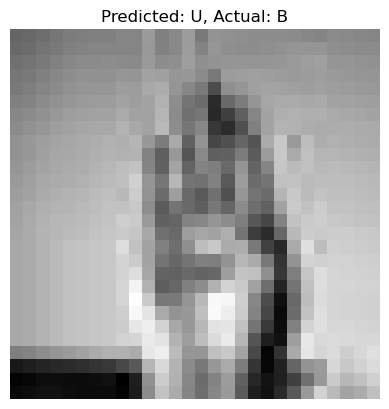

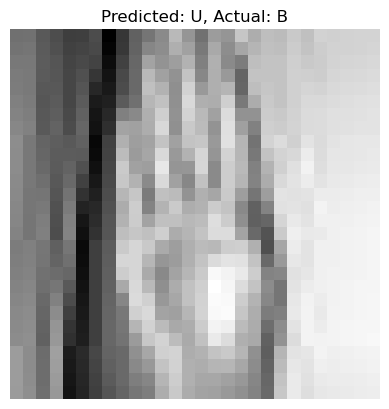

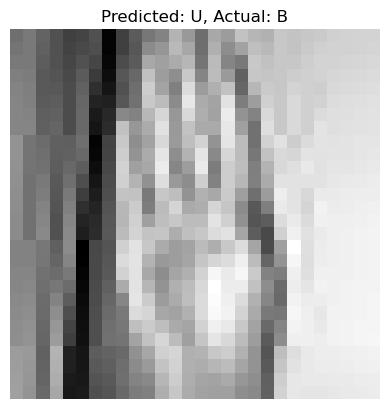

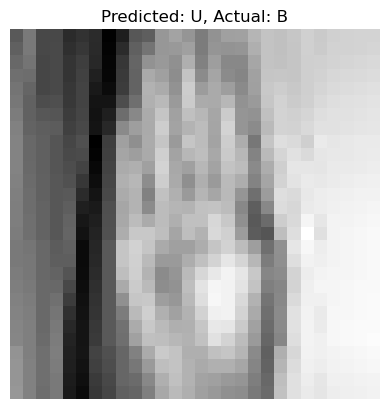

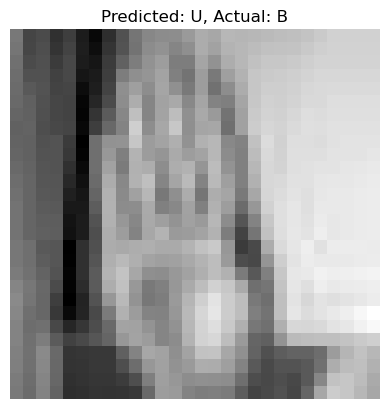

In [29]:
for i in range(min(5, len(incorrect))):
    img, pred, label = incorrect[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {inv_label_mapping[pred.item()]}, Actual: {inv_label_mapping[label.item()]}")
    plt.axis('off')
    plt.show()